In [68]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [69]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [70]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [71]:
# create engine to hawaii.sqlite
database_path = "Resources/hawaii.sqlite"

engine = create_engine(f"sqlite:///{database_path}")

In [72]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [73]:
# View all of the classes that automap found
Base.classes.keys()

# ANother way to find tables NOTE: must import inspect from sqlalchemy
inspector = inspect(engine)
print(f"Table Names: {inspector.get_table_names()}")

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])


Table Names: ['measurement', 'station']
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [74]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [75]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [76]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [77]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1)

for row in most_recent_date:
    print(f"The most recent date is : {row[0]}")

The most recent date is : 2017-08-23


Most recent date: 2017-08-23 00:00:00
One year prior: 2016-08-23 00:00:00


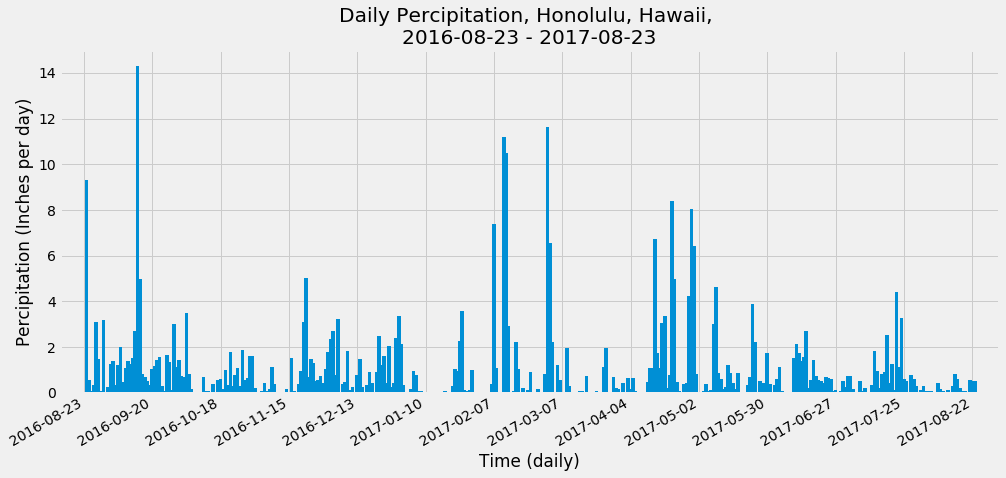

In [78]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

start_date = dt.datetime.strptime([row[0] for row in most_recent_date][0], '%Y-%m-%d')
print(f"Most recent date: {start_date}")

# Calculate the date one year from the last date in data set.
end_date = start_date - dt.timedelta(days=365)
print(f"One year prior: {end_date}")

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).filter(Measurement.date >= end_date)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'prcp'])
df['date'] = pd.to_datetime(df['date'])

df.set_index('date', inplace = True)

# Sort the dataframe by date
df = df.groupby('date').agg(prcp = ('prcp', 'sum'))

# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots(1,1, figsize = (15,7))

ax.bar(x=df.index.values, height = df.prcp, width = 1.5)

# # Define the date format
date_form = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))

ax.set(
    xlabel = 'Time (daily)',
    ylabel = 'Percipitation (Inches per day)',
    title = 'Daily Percipitation, Honolulu, Hawaii, \n2016-08-23 - 2017-08-23',
    xlim = (end_date - dt.timedelta(days = 10), start_date + dt.timedelta(days = 10))
)

fig.autofmt_xdate()

plt.show()


In [79]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()


,prcp
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


# Exploratory Station Analysis

In [80]:
# Design a query to calculate the total number stations in the dataset
results = session.query(Measurement.station).group_by(Measurement.station)

count=0
for row in results:
    print(row[0])
    count+=1
    
print(f"Total Number of Stations: {count}")

USC00511918
USC00513117
USC00514830
USC00516128
USC00517948
USC00518838
USC00519281
USC00519397
USC00519523
Total Number of Stations: 9


In [81]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

for row in station_counts:
    print(row)

mst_act_station = station_counts[0][0]
print(f"The most active station is: {mst_act_station}")

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)
The most active station is: USC00519281


In [82]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == mst_act_station)

print(temps[0])

print(f"The most active station is: {temps[0][0]}")
print(f"The min temperature recorded is: {temps[0][1]}")
print(f"The max temperature recorded is: {temps[0][2]}")
print(f"The avg temperature recorded is: {temps[0][3]}")

('USC00519281', 54.0, 85.0, 71.66378066378067)
The most active station is: USC00519281
The min temperature recorded is: 54.0
The max temperature recorded is: 85.0
The avg temperature recorded is: 71.66378066378067


[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Temperature (F)'),
 Text(0.5, 1.0, 'Temperature Grouping Frequency, Honolulu, Hawaii,\nStation: USC00519281, 2016-08-23 - 2017-08-23')]

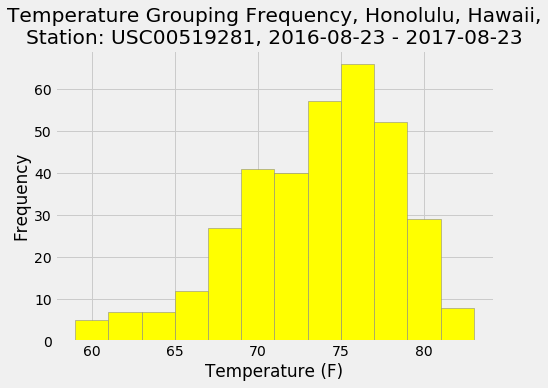

In [83]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).filter((Measurement.station == mst_act_station) & (Measurement.date >= end_date))

mst_act_station_df = pd.DataFrame(results, columns = ['tobs'])

fig, ax = plt.subplots(1,1,figsize=(7,5))

ax.hist(mst_act_station_df['tobs'], bins = 12, facecolor = 'yellow', edgecolor = 'grey')

ax.set(
    xlabel = 'Temperature (F)',
    ylabel = 'Frequency',
    title = f'Temperature Grouping Frequency, Honolulu, Hawaii,\nStation: {mst_act_station}, 2016-08-23 - 2017-08-23',
)

# Close session

In [84]:
# Close Session
session.close()